In [27]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from jepa.utils import set_seed
from jepa.dataset import load_cifar, load_mnist
from jepa.model.autoencoder import AutoEncoder, AutoencoderCriterion
from jepa.model.jepa import Jepa
import json

## Autoencoder

In [28]:
device = "cpu" if not torch.cuda.is_available() else "cuda"
print("Using device: ", device)

seed = 30
wandb_project = "jepa-prove"

batch_size = 64
test_size = 2048

Using device:  cpu


In [29]:
chkpt_dir = "../checkpoints/AutoEncoder/mnist-train"
model, chkpt_metadata = AutoEncoder.from_pretrained(chkpt_dir, device)
print(json.dumps(chkpt_metadata, indent=2))

{
  "step": 2560,
  "epoch": 10,
  "date": "2024-04-18 13:09:20",
  "optimizer": {
    "lr": 0.0005,
    "betas": [
      0.9,
      0.999
    ],
    "eps": 1e-08,
    "weight_decay": 0.1,
    "amsgrad": false,
    "foreach": null,
    "maximize": false,
    "capturable": false,
    "differentiable": false,
    "fused": null,
    "type": "AdamW"
  },
  "architecture": {
    "type": "AutoEncoder",
    "input_dim": 784,
    "hidden_layers": [
      784,
      30
    ],
    "activation": "ReLU",
    "decoder_hidden": [
      784
    ]
  },
  "hyperparameters": {
    "lr": 0.0005,
    "rho": null,
    "batch_size": 64,
    "max_epochs": 10,
    "weight_decay": 0.1,
    "optimizer": "AdamW",
    "criterion": {
      "criterion": "AutoencoderCriterion",
      "reconstruction_error": "MSELoss",
      "sparsity_weight": 0.0
    },
    "scheduler": null,
    "train_size": 16384,
    "test_size": 2048,
    "target_loss": 0.0,
    "seed": 30,
    "compile_model": true,
    "train_set_percentage_f

In [30]:
id = chkpt_metadata["train_set"]["id"]
if "mnist" in id:
    load_dataset = load_mnist
elif "cifar10" in id:
    def load_dataset(**kwargs):
        return load_cifar(num_classes=10, **kwargs)
elif "cifar100" in id:
    def load_dataset(**kwargs):
        return load_cifar(num_classes=100, **kwargs)
else:
    raise ValueError("Unknown dataset")

train_size = chkpt_metadata["train_set"]["num_samples"]
test_size = chkpt_metadata["test_set"]["num_samples"]
shuffle = chkpt_metadata["train_set"]["shuffle"]  # assume same shuffle for test set (!)

In [31]:
# dataset
root = "../data"
train_dataset, train_metadata = load_dataset(train=True, log_to_wandb=False, 
    project=wandb_project, root=root, jepa=False, shuffle=seed, num_samples=train_size)
test_dataset, test_metadata = load_dataset(train=False, log_to_wandb=False, 
    project=wandb_project, root=root, jepa=False, shuffle=seed, num_samples=test_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=test_size)  # be mindful of the batch size

In [32]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=784, bias=True)
    (1): ReLU()
    (2): Linear(in_features=784, out_features=30, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=784, bias=True)
    (1): ReLU()
    (2): Linear(in_features=784, out_features=784, bias=True)
  )
)

### Classification

In [33]:
from jepa.evaluation import train_classifier, build_dataset_of_latents
from matplotlib import pyplot as plt


train_latents_dataset = build_dataset_of_latents(model.encoder, train_loader, device)
train_latents_dl = DataLoader(train_latents_dataset, batch_size=batch_size, shuffle=True)
test_latents_dataset = build_dataset_of_latents(model.encoder, test_loader, device)
test_latents_dl = DataLoader(test_latents_dataset, batch_size=test_size, shuffle=False)
num_classes = len(train_latents_dataset.labels.unique())

Final accuracy:  0.89404296875 Max accuracy:  0.8955078125


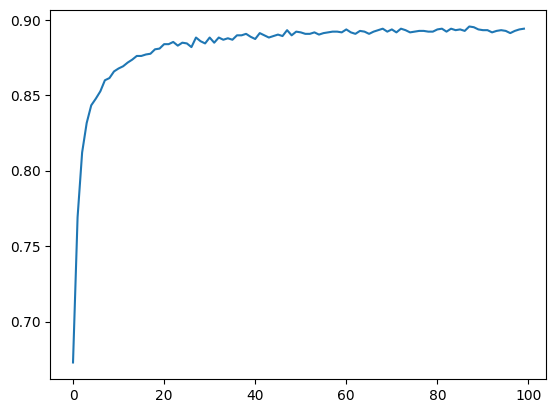

In [34]:
latent_dim = next(iter(train_latents_dl))['x'].shape[1]
classifier = nn.Linear(latent_dim, num_classes)
optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-3, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

accs = train_classifier(classifier, train_latents_dl, test_latents_dl, criterion=criterion,
                        optimizer=optimizer, epochs=100, device=device)

plt.plot(accs)
print("Final accuracy: ", accs[-1], "Max accuracy: ", max(accs))
plt.show()

Final accuracy:  0.900390625 Max accuracy:  0.90771484375


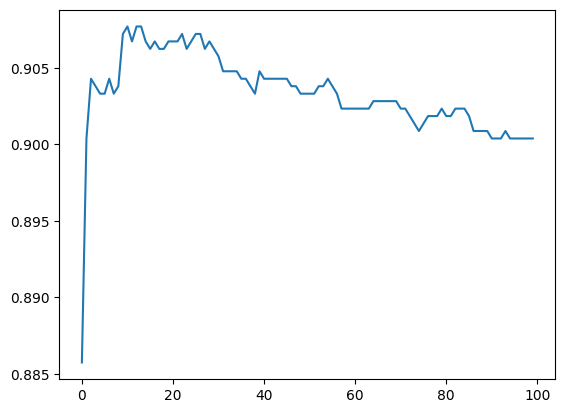

In [ ]:
input_dim = next(iter(train_loader))['x'].shape[1]
classifier = nn.Linear(input_dim, num_classes).to(device)
optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-3, weight_decay=1e-3)

accs = train_classifier(classifier, train_loader, test_loader,
                                   optimizer, epochs=100, device=device)

plt.plot(accs)
print("Final accuracy: ", accs[-1], "Max accuracy: ", max(accs))
plt.show()

In [15]:
next(iter(train_loader))["x"].shape

torch.Size([64, 784])

## Jepa

In [13]:
device = "cpu" if not torch.cuda.is_available() else "cuda"
print("Using device: ", device)

seed = 30
wandb_project = "jepa-prove"

batch_size = 64
test_size = 2048

Using device:  cpu


In [14]:
chkpt_dir = "../checkpoints/Jepa/mnist-train"
model, chkpt_metadata = Jepa.from_pretrained(chkpt_dir, device)
print(json.dumps(chkpt_metadata, indent=2))

{
  "step": 7680,
  "epoch": 30,
  "date": "2024-04-17 12:39:38",
  "optimizer": {
    "lr": 0.001,
    "betas": [
      0.9,
      0.999
    ],
    "eps": 1e-08,
    "weight_decay": 0.1,
    "amsgrad": false,
    "foreach": null,
    "maximize": false,
    "capturable": false,
    "differentiable": false,
    "fused": null,
    "type": "AdamW"
  },
  "architecture": {
    "type": "Jepa",
    "encoder": "Sequential(\n  (0): Linear(in_features=784, out_features=30, bias=True)\n)",
    "predictor": "Sequential(\n  (0): Linear(in_features=30, out_features=30, bias=True)\n)"
  },
  "hyperparameters": {
    "lr": 0.001,
    "rho": null,
    "batch_size": 64,
    "max_epochs": 30,
    "weight_decay": 0.1,
    "optimizer": "AdamW",
    "criterion": {
      "criterion": "JepaCriterion",
      "reconstruction_error": "MSELoss",
      "sparsity_weight": 0.0
    },
    "scheduler": null,
    "train_size": 16384,
    "test_size": 2048,
    "target_loss": 0.0,
    "seed": 30,
    "compile_model": t

In [15]:
id = chkpt_metadata["train_set"]["id"]
if "mnist" in id:
    load_dataset = load_mnist
elif "cifar10" in id:
    def load_dataset(**kwargs):
        return load_cifar(num_classes=10, **kwargs)
elif "cifar100" in id:
    def load_dataset(**kwargs):
        return load_cifar(num_classes=100, **kwargs)
else:
    raise ValueError("Unknown dataset")

train_size = chkpt_metadata["train_set"]["num_samples"]
test_size = chkpt_metadata["test_set"]["num_samples"]
shuffle = chkpt_metadata["train_set"]["shuffle"]  # assume same shuffle for test set (!)

In [16]:
# dataset
root = "../data"
train_dataset, train_metadata = load_dataset(train=True, log_to_wandb=False, 
    project=wandb_project, root=root, jepa=False, shuffle=seed, num_samples=train_size)
test_dataset, test_metadata = load_dataset(train=False, log_to_wandb=False, 
    project=wandb_project, root=root, jepa=False, shuffle=seed, num_samples=test_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=test_size)  # be mindful of the batch size

In [17]:
model

Jepa(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=30, bias=True)
  )
  (predictor): Sequential(
    (0): Linear(in_features=30, out_features=30, bias=True)
  )
  (ema): Sequential(
    (0): Linear(in_features=784, out_features=30, bias=True)
  )
)

In [7]:
batch = next(iter(test_loader))
batch

{'x': tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]),
 'y': tensor([5, 9, 1,  ..., 9, 0, 8])}

In [8]:
x = batch["x"].to(device)
y = batch["y"]

In [9]:
latents = model.encode(x)
torch.abs(latents).mean()